# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
# Подключим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from numpy.random import RandomState

## Загрузка и подготовка данных

В ходе загрузи и подготовки данных будет выполнено:
1. Загрузим и сохраним данные с переменные.
2. Ознакомимся с данными, посмотрим на статистики, общую информацию, посмотрим наличие пропусков и дубликатов.
3. Визуально познакомимся с данными, посмотрим на корреляцию признаков и на распределение данных.
4. Подготовим данные для обучения модели. Разделим датасеты на признаки и целевой признак, разделим данные на обучающую и валидационную выборки, промасштабируем данные и, при необходимости, исключим столбцы из датасета, которые не влияют на целевой признак. 

In [4]:
# Загрузим данные по регионам и сохраним их в переменных location_1, location_2, location_3
location_1 = pd.read_csv('geo_data_0.csv')
location_2 = pd.read_csv('geo_data_1.csv')
location_3 = pd.read_csv('geo_data_2.csv')

In [5]:
locations = [location_1, location_2, location_3]

### Ознакомление с данными 

In [6]:
# Познакомимся с данными, отобразим первые 5 строк в каждом датасете
display(location_1.head())
display(location_2.head())
location_3.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В каждом датасете по 5 столбцов:
- `id` - зашифрованное название месторождения/скважины
- `f1`, `f2` и `f3` - характеристики
- `product` - объём запасов в скважине (тыс. баррелей) - **целевая переменная**.

Для обучения модели машинного обучения данные из столбца `id` нужно будет исключить, т.к название скважины никак не влияют на целевую переменную.

### Общая информация по датасетам

In [7]:
# Посмотрим на общую информацию по данным с каждого региона
location_1.info()
location_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
location_2.info()
location_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [9]:
location_3.info()
location_3.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [10]:
# Проверим датасеты на наличие дубликатов
display(location_1.duplicated().sum())
display(location_2.duplicated().sum())
location_3.duplicated().sum()

0

0

0

При ознакомлении с общей информацией по данным было выявлено:
1. В данных нет пропусков, во всех датасетах по 100000 строк.
2. В столбцах: `f1`, `f2`, `f3` и `product` тип данных - `float64`. Изменение типов данных не требуется.
3. Отсутствуют явные дубликаты а датасетах.

Данные в столбцах `f1`, `f2` и `f3` в разным масшатобом, для корректного обучения модели машинного обучения необходимо в дальнейшем стандартизровать данные в этих столбцах.

### Корреляция данных в датасете

In [11]:
# Создадим собственную функцию для отображения теплово карты по корреляции в едином стиле
def corr_heatmap(data, name):
    plt.figure(figsize=(10,3))
    plt.title(f'Теловая карта корреляции признаков {name}', fontsize=14)
    sns.heatmap(data.corr(), 
                annot=True,
                linewidth=0.5,
                cmap='Blues'
               )

/var/folders/zq/yp8ktgrj2b12__tc31v8lj0h0000gn/T/ipykernel_87081/3163299402.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),


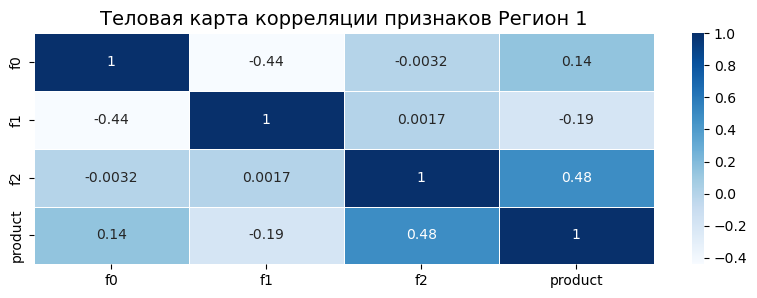

In [12]:
# Корреляция признаков в Регионе 1
corr_heatmap(location_1, "Регион 1")

/var/folders/zq/yp8ktgrj2b12__tc31v8lj0h0000gn/T/ipykernel_87081/3163299402.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),


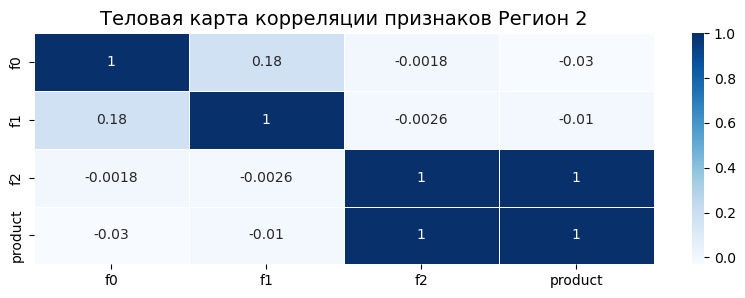

In [13]:
# Корреляция признаков в Регионе 2
corr_heatmap(location_2, 'Регион 2')

/var/folders/zq/yp8ktgrj2b12__tc31v8lj0h0000gn/T/ipykernel_87081/3163299402.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),


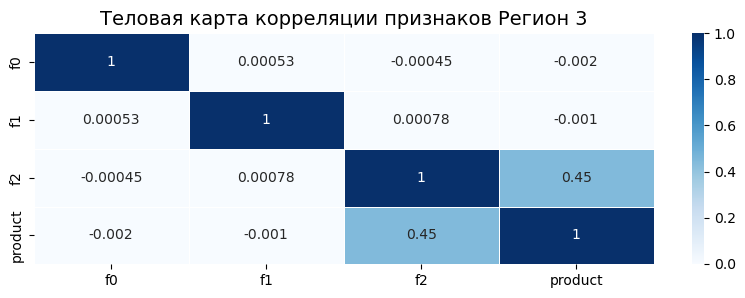

In [14]:
# Корреляция признаков в Регионе 3
corr_heatmap(location_3, 'Регион 3')

По тепловой диаграмме коррляции признаков видно, что на продуктивность скважины больше всего влияет признак **f2**

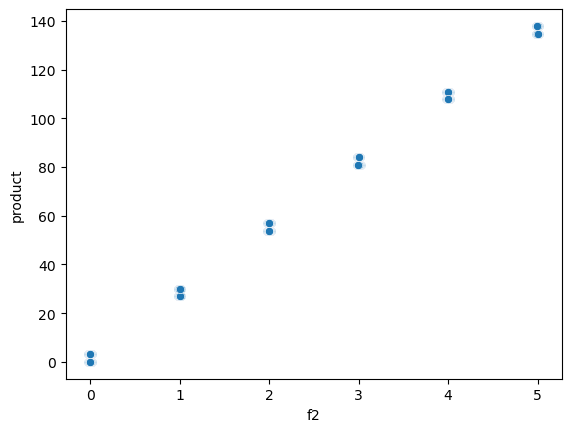

In [15]:
sns.scatterplot(data=location_2, x=location_2['f2'], y=location_2['product']);

### Распределение данных

Посмотрим на распределение данных в датасетах.

Создадим фунцию `data_hist`, которая выдаст гистограммы для каждого признака из датасета.

In [16]:
def data_hist(data, name):
    print(f'Распредение данных. {name}')
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    ax[0].hist(data['f0'], bins=50, )
    ax[0].set(title='f1')

    ax[1].hist(data['f1'], bins=50)
    ax[1].set(title='f2')

    ax[2].hist(data['f2'], bins=50)
    ax[2].set(title='f3')

    ax[3].hist(data['product'], bins=50)
    ax[3].set(title='product')

    plt.show()

Распредение данных. Регион 1


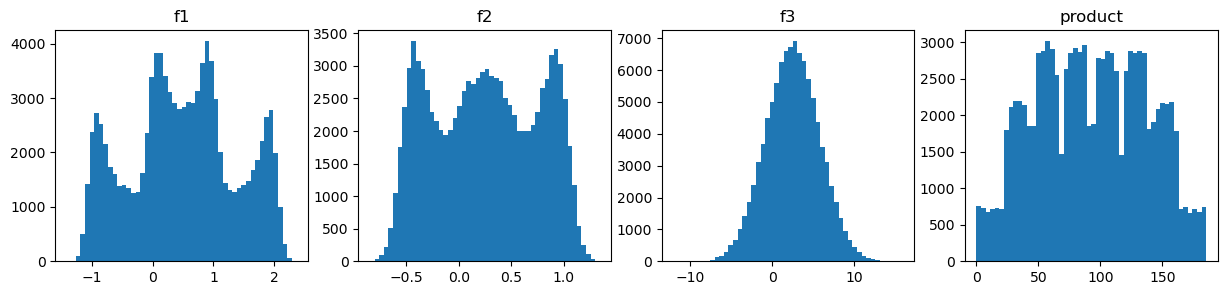

In [17]:
data_hist(location_1, 'Регион 1')

Распредение данных. Регион 2


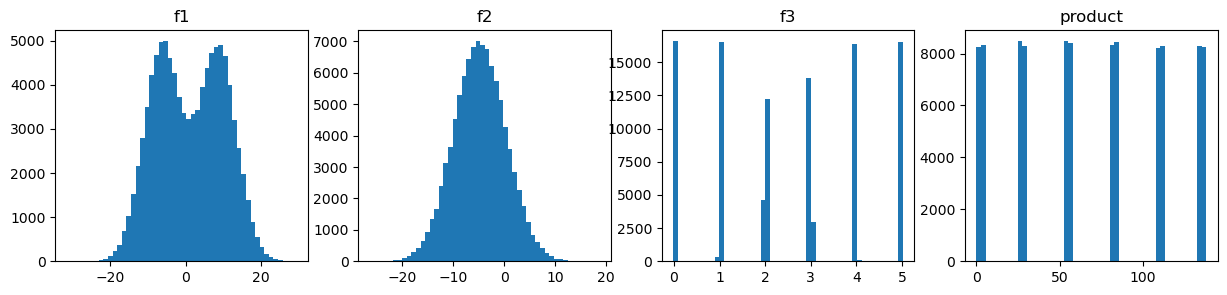

In [18]:
data_hist(location_2, "Регион 2")

Распредение данных. Регион 3


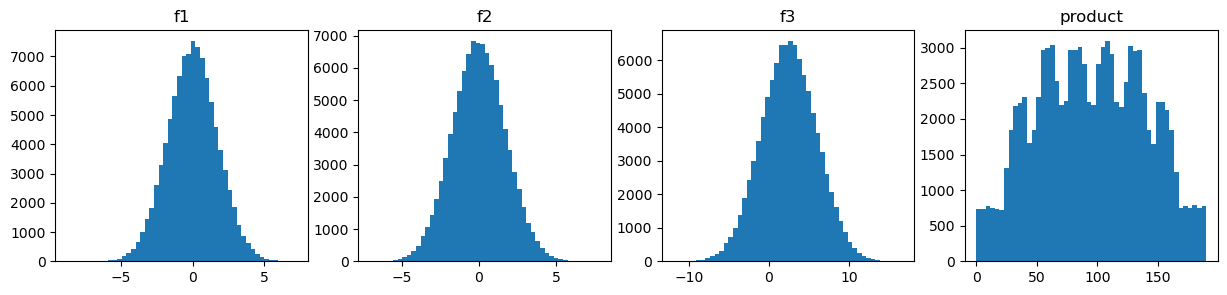

In [19]:
data_hist(location_3, "Регион 3")

Из гистрограмм видно, что нормально распределены признаки только в датасете по 3-му региону. В регионах 1 и 2 данные распределены не нормально, что, скорее всего, связано с тем, что данные синтетические.
Возможно, что такое распределение данных повлияет на результаты обучения модели Линейной регрессии.

### Исключение столбцов из датасета

В датасетах пристутствуют стобец с названием скважины, удалим его т.к. этот признак никак не влияет на целевой признак `product`. Сохраним данные в новых переменных например `good_loc_1` 

In [20]:
good_loc_1 = location_1.drop('id', axis=1)
good_loc_2 = location_2.drop('id', axis=1)
good_loc_3 = location_3.drop('id', axis=1)

In [21]:
# Проверим удалился ли столбец 'id'
good_loc_1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


### Разделение данных на признаки и целевой признак

Разделим данные по каждому региону на датасеты с признаками - features, и целевым признаком target.

In [29]:
# Напишем собственную функцию по разделению данных на признаки и целевой признак
def features_target(data):
    '''Возращает 2 датасета: 1 - признаки, 2 - целевой признак'''
    features = data.drop('product', axis=1)
    target = data['product']
    return features, target

Создадим датасеты по каждому региону

In [30]:
# Регион_1
features_loc_1, target_loc_1 = features_target(good_loc_1)

# Регион_2
features_loc_2, target_loc_2 = features_target(good_loc_2)

# Регион_3
features_loc_3, target_loc_3 = features_target(good_loc_3)

In [31]:
# Проверим правильность разделения данных
display(features_loc_1.head())
target_loc_1.head()

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769


0    105.280062
1     73.037750
2     85.265647
3    168.620776
4    154.036647
Name: product, dtype: float64

### Разделение данных на обучающую и валидиционную выборки

In [38]:
# Напишем собственную функцию по разделению данных на обучающую и валидационную выборки
def split_data(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  random_state=123,
                                                                                  test_size=0.25)
    return features_train, features_valid, target_train, target_valid

Разделим датасеты на обучающие и валидационные выборки

In [40]:
# Регион_1
features_train_loc_1, features_valid_loc_1, target_train_loc_1, target_valid_loc_1 = split_data(features_loc_1,
                                                                                                target_loc_1)

# Регион_2
features_train_loc_2, features_valid_loc_2, target_train_loc_2, target_valid_loc_2 = split_data(features_loc_2,
                                                                                                target_loc_2)

# Регион_3
features_train_loc_3, features_valid_loc_3, target_train_loc_3, target_valid_loc_3 = split_data(features_loc_3,
                                                                                                target_loc_3)

In [34]:
# Проверим правильно ли разделились данные на примере датасета 1 региона
print(f'''
Размер обучающей выборки: {features_train_loc_1.shape}
Размер валидационной выборки: {features_valid_loc_1.shape}
''')


Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)



### Масштабирование данных

Промасштабируем данные в столбцах `f0`, `f1` и `f2` в датасетах для каждого региона

In [26]:
# Создадим собственную функцию по масшабированию данных для ускорения
pd.options.mode.chained_assignment = None

numeric = ['f0', 'f1', 'f2']
def scale_features(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid

In [27]:
# Регион_1
features_train_loc_1, features_valid_loc_1 = scale_features(features_train_loc_1, 
                                                            features_valid_loc_1)

# Регион_2
features_train_loc_2, features_valid_loc_2 = scale_features(features_train_loc_2, 
                                                            features_valid_loc_2)

# Регион_3
features_train_loc_3, features_valid_loc_3 = scale_features(features_train_loc_3, 
                                                            features_valid_loc_3)

In [35]:
# Проверим правильность масшабирования данных
features_train_loc_1.head()

,f0,f1,f2
31450,0.304856,-0.439498,6.551519
42809,0.585391,0.964728,0.463974
52419,0.339017,0.921952,2.210054
45663,-0.982766,0.410923,-3.243633
50696,-0.450268,0.738422,4.349805


### Вывод по разделу

В ходе раздела были выполнены следующие работы:
1. Подгружены данные и сохранены в переменных.
2. Ознакомились с общей информацией по датасету. Не было необходимости изменять типы данных в столбцах, в данных отсутствуют явные дубликаты. 
3. Постоили тепловую карту по корреляции данных, было выявлено, что на продуктивность скважины больше всего влият признак **f3**.
4. Посмотрели на распределение данных в датасетах, было выявлено, что в регионах 1 и 2 данные распределены не нормально, что, скорее всего, связано с тем, что данные синтетические.
5. Перед формированием обучающих выборок был исключен из датасета столбец `id`, т.к. название скважины никак не влияет на целевой признак `product`. 
6. Данные по каждому региону были разделены на датасеты с признаками - features, и целевым признаком target, далее были разделены на обучающие и валидационные выборки.
7. Промасштабированы данные в столбцах `f0`, `f1` и `f2` в датасетах для каждого региона


## Обучение и проверка модели

### Обучение моделей

Для прогнозирования продуктивности скважин обучим модели линейной регрессии (LinearRegression) для каждого региона.

In [29]:
# Создадим собственную функцию по обучению моделей
# функция возращает предсказания в Series и показатель RMSE
def linear_reg_model(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    score = mean_squared_error(target_valid, predictions) ** 0.5
    return pd.Series(predictions), score

In [30]:
# Обучим модель для первого региона
predictions_loc_1, score_loc_1 = linear_reg_model(features_train_loc_1, 
                                                  features_valid_loc_1, 
                                                  target_train_loc_1, 
                                                  target_valid_loc_1)

print(f'''
Регион 1
Средний запас предсказанного сырья: {predictions_loc_1.mean()}
RMSE: {score_loc_1}
''')


Регион 1
Средний запас предсказанного сырья: 92.54936189116309
RMSE: 37.64786282376177



In [31]:
# Обучим модель для второго региона
predictions_loc_2, score_loc_2 = linear_reg_model(features_train_loc_2,
                                                  features_valid_loc_2,
                                                  target_train_loc_2,
                                                  target_valid_loc_2)

print(f'''
Регион 2
Средний запас предсказанного сырья: {predictions_loc_2.mean()}
RMSE: {score_loc_2}
''')


Регион 2
Средний запас предсказанного сырья: 69.28001860653976
RMSE: 0.8954139804944314



In [32]:
# Обучим модель для третьего региона
predictions_loc_3, score_loc_3 = linear_reg_model(features_train_loc_3,
                                                 features_valid_loc_3,
                                                 target_train_loc_3,
                                                 target_valid_loc_3)

print(f'''
Регион 3
Средний запас предсказанного сырья: {predictions_loc_3.mean()}
RMSE: {score_loc_3}
''')


Регион 3
Средний запас предсказанного сырья: 95.09859933591373
RMSE: 40.12803006598514



После обучения моделей линейной регресии, получили следующие результаты:
1. Регион 1
    - Средний запас предсказанного сырья: 92.54936189116309 - **Наибольший показатель**
    - RMSE: 37.64786282376177
2. Регион 2
    - Средний запас предсказанного сырья: 69.28001860653976
    - RMSE: 0.8954139804944314 - **Наилучший показатель**
3. Регион 3
    - Средний запас предсказанного сырья: 95.09859933591373
    - RMSE: 40.12803006598514

Наилучший показатель RMSE получился по второму региону, это должно быть связано с прямой корреляцией между признаком `f2` и `product`.

### Сохранение предсказаний и таргетов

Сохраним предсказанные значения и таргеты по скважинам из валидационной выборки в один датафрейм по кадому региону.

In [33]:
# Напишем собственную функцию для ускорения процесса
def predictions_target_df(predictions, target):
    '''
    Возращает датафрейм с 2 столбцами
    1 столбец - предсказания по модели
    2 столбец - таргеты из target_valid
    '''
    predictions_target = pd.DataFrame(columns=['predictions', 'target'])
    predictions_target['predictions'] = predictions
    predictions_target['target'] = target
    return predictions_target

In [34]:
# Регион 1
pred_target_loc_1 = predictions_target_df(predictions_loc_1, target_valid_loc_1)

# Регион 2
pred_target_loc_2 = predictions_target_df(predictions_loc_2, target_valid_loc_2)

# Регион 3
pred_target_loc_3 = predictions_target_df(predictions_loc_3, target_valid_loc_3)

In [35]:
# Проверим как сформировались датафреймы
pred_target_loc_1

,predictions,target
42083,123.284256,145.825972
71825,75.838240,134.020212
99535,55.526760,88.905826
47879,86.673045,19.508226
36734,109.909327,108.713468
...,...,...
56405,89.708779,80.100250
50954,55.672078,47.345664
99121,139.042911,176.382705
4170,96.867927,140.334745


## Подготовка к расчёту прибыли

Экономические показатели разработки месторождения.
- Бюджет на разработку месторождения 10_000_000_000 руб.
- Количество скважин - 200 шт.
- Доход с 1000 баррелей - 450_000 руб.
- Пороговое значение вероятности убытков - 2.5%.

In [36]:
# Сохраним экономические показатели в переменных
BUDJET = 10_000_000_000
WELLS = 200
INCOME_1000bbls = 450_000
LOSS_PROB = 0.025

In [37]:
# Найдем минимальные запасы месторождения, для выхода в точку безубыточности при разработке
min_reserves = BUDJET / (WELLS * INCOME_1000bbls)
min_reserves

111.11111111111111

Минимальные необходимые запасы для безубыточной разработки месторождения - 111.11 тыс.баррелей.

Наиболее близкими средними запасами нефти являются запасы по скважинам из 3 региона - **95.1 тыс.баррелей**, далее идёт 1 регион со средними запасами **92.5. тыс.баррелей**, наименьшие средние запасы по 2 региону - **69.3 тыс.баррелей**.

## Расчёт прибыли и рисков 

### Подсчет максимально возможной прибыли

In [38]:
# Напишем собственную функцию по расчету максимально возмодной прибыли для региона 
# при выборе самых продуктивных скважин
def profit(pred_target):
    best_200_pred_wells = pred_target.sort_values(by='predictions', ascending=False)[:200]
    best_200_wells = best_200_pred_wells['target']
    max_income = best_200_wells.sum() * INCOME_1000bbls - BUDJET
    return max_income

In [39]:
# Расчитаем максиамльно возможную прибыль с Региона 1
max_profit_loc_1 = profit(pred_target_loc_1)
print(f'Максимально возможная прибыль: {(max_profit_loc_1/1_000_000).round(2)} млн.руб')

Максимально возможная прибыль: 3534.67 млн.руб


In [40]:
# Расчитаем максиамльно возможную прибыль с Региона 1
max_profit_loc_2 = profit(pred_target_loc_2)
print(f'Максимально возможная прибыль: {(max_profit_loc_2/1_000_000).round(2)} млн.руб')

Максимально возможная прибыль: 2415.09 млн.руб


In [41]:
# Расчитаем максиамльно возможную прибыль с Региона 1
max_profit_loc_3 = profit(pred_target_loc_3)
print(f'Максимально возможная прибыль: {(max_profit_loc_3/1_000_000).round(2)} млн.руб')

Максимально возможная прибыль: 2370.34 млн.руб


### Расчет прибыли и рисков

Найдем среднюю прибыли с разработки месторождений, посчитаем 95% доверительный инвервал прибыли с разработки месторождений на регионах, путем формирования 1000 выборок с помощью техники Bootstrap, так же посчитаем риск убытков.

In [42]:
state = RandomState(123)

In [43]:
def probability_loss(pred_target):
    values = []
    for i in range(1000):
        wells_500 = pred_target.sample(n=500,
                                       random_state=state,
                                       replace=True)
        value = profit(wells_500)
        values.append(value)
        
    print(f'''
    Средняя прибыль: {(pd.Series(values).mean() / 1_000_000).round(2)} млн.руб.
    95%-й доверительный интервал: {(pd.Series(values)
    .quantile(0.025) / 1_000_000).round(2)} - {(pd.Series(values).quantile(0.975) / 1_000_000).round(2)} млн.руб.
    Риск убытков: {(pd.Series(values) < 0).sum() / 1000 * 100}%.
    ''')

In [44]:
# Посчитаем прибыли и риски для Региона 1
probability_loss(pred_target_loc_1)


    Средняя прибыль: 477.42 млн.руб.
    95%-й доверительный интервал: -57.99 - 974.82 млн.руб.
    Риск убытков: 4.1000000000000005%.
    


In [45]:
# Посчитаем прибыли и риски для Региона 2
probability_loss(pred_target_loc_2)


    Средняя прибыль: 467.48 млн.руб.
    95%-й доверительный интервал: 68.76 - 871.49 млн.руб.
    Риск убытков: 1.0%.
    


In [46]:
# Посчитаем прибыли и риски для Региона 3
probability_loss(pred_target_loc_3)


    Средняя прибыль: 362.13 млн.руб.
    95%-й доверительный интервал: -182.99 - 870.97 млн.руб.
    Риск убытков: 8.9%.
    


По результатам расчетов **наименьший риск потерь - 1%** при разработке **Региона 2**, средняя прибыль при этом 467.48 млн. руб (95% доверительный инвервал 68.76 - 871.49 млн.руб).

Максимальный риск потерь - 8.9% при разработке Региона 3.

## Общий вывод

В ходе выполнения проекта были выполенны следующие шаги:
1. Подгрузка и изнакомление с данными:
 - Ознакомились с общей информацией по датасетам; 
 - Посмотрели на корреляцию признаков;
 - Графически ознакомились с данными;
 - Подготовили данные для обучения модели машинного обучения (масштабирование, разделение датасетов на признаки и целевой признак, разделение датасетов на обучающие датасеты и валидационные).
2. Обучена модель линейной регресии для каждого региона, и получили следущие результаты:
    
    1) Регион 1
        - Средний запас предсказанного сырья: 92.54936189116309 - Наибольший показатель
        - RMSE: 37.64786282376177
    2) Регион 2
        - Средний запас предсказанного сырья: 69.28001860653976
        - RMSE: 0.8954139804944314 - Наилучший показатель
    3) Регион 3
        - Средний запас предсказанного сырья: 95.09859933591373
        - RMSE: 40.12803006598514
3. Нашли минимальный средний объем запасов по каждой из 200 скважин для выхода в точку безубыточности, который составил 111.11 тыс.баррелей.
4. Расчитали прибыли и риски по каждому региону.

После проведенной работы для разработки нефтяных месторождений рекомендуется выбрать **Регион 2**, в связи с **минимальным риском потерь при разработке (1 %)**, по сравнению с Регионом 1 (4.1% риска потерь) и Регионом 3 (8.9% риска потерь).

Максимально возможная прибыль при разрабоке (в случае бурения наиболее продуктивных скважин) Региона 2 составляет - 2.415 млрд.руб.

Средняя прибыль при разработке Региона 2 составляет 467.48 млн.руб. 95% доверительный интервал при этом: 68.76 - 871.49 млн.руб.